In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

np.random.seed(37)

In [132]:
# Data Load
df_train = pd.read_csv('train.csv')
df_train = df_train.iloc[:,1:]
df_train.columns = ['hour', 'temp', 'precip',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2_5', 'count']
df_X = df_train[df_train.columns.drop('count')]
df_y = df_train['count'].values

In [163]:
# Data Preprocessing
numeric_features = list(df_X.columns.drop(['precip','hour']))
numeric_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='median')),("scaler",StandardScaler())]
)
hour_feature = ['hour']
hour_transformer = Pipeline(
    steps=[("imputer",SimpleImputer(strategy='most_frequent')),('scaler',StandardScaler(with_std=False))]
 ) # hour은 standardscaler에서 표준편차로 나누는 것은 제외함.
hour_transformer_oh = OneHotEncoder(handle_unknown='ignore',sparse=False) # hour을 onehotencoding으로 처리

categorical_features = ['precip']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor_1 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('hour', hour_transformer, hour_feature),
        ("cat", categorical_transformer, categorical_features)
    ]
)
preprocessor_2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('hour', hour_transformer_oh, hour_feature),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [137]:
# Visualize Pipeline
from sklearn import set_config

set_config(display="diagram")

In [173]:
# Principal Component Regression by pipeline
pca_1 = Pipeline(
    steps=[("preprocessor",preprocessor_1),("pca",PCA(n_components=10))]
)
pca_2 = Pipeline(
    steps=[("preprocessor",preprocessor_2),("pca",PCA(n_components=10))]
)
X_train, X_val, y_train, y_val = train_test_split(df_X, df_y, test_size=0.3, random_state=0)
pca_1.fit(X_train,y_train)
pca_2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'windspeed',
                                                   'humidity', 'visibility',
                                                   'ozone', 'pm10', 'pm2_5']),
                                                 ('hour',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['precip'])])),
                ('pca', PCA(n_components=10))])

In [190]:
# PCA result
pca_step_1 = pca_1.named_steps['pca'] # load pca step for pca_1
pca_1_ratio = pca_step_1.explained_variance_ratio_.round(3)

pca_step_2 = pca_2.named_steps['pca']  # load pca step for pca_2
pca_2_ratio = pca_step_2.explained_variance_ratio_.round(3)

pca_res = pd.DataFrame([pca_1_ratio,pca_2_ratio], index=['Scaler','One-hot'], columns=range(1,11,1)).T
pca_res.iloc[:3,:].sum(axis=0) # Ex.ratio of first three components

Scaler     0.954
One-hot    0.673
dtype: float64

In [192]:
# PCR
from sklearn.linear_model import LinearRegression
pcr = Pipeline(
    steps=[('Preprocessor',preprocessor_1),
    ('PCA',PCA(n_components=3)),
    ('Linear',LinearRegression())]
)
pcr.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'windspeed',
                                                   'humidity', 'visibility',
                                                   'ozone', 'pm10', 'pm2_5']),
                                                 ('hour',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler(with_std=False))]),
                                                  ['hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['precip'])])),
                ('PCA', PCA(n_components=3)), ('Linear', LinearRegression())])

In [194]:
# PLS
from sklearn.cross_decomposition import PLSRegression
pls = Pipeline(
    steps=[("Preprocessor",preprocessor_1),
    ('PLS', PLSRegression(n_components=3))]
)
pls.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'windspeed',
                                                   'humidity', 'visibility',
                                                   'ozone', 'pm10', 'pm2_5']),
                                                 ('hour',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler(with_std=False))]),
                                                  ['hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['precip'])])),
                ('PLS', PLSRegression(n_components=3))])

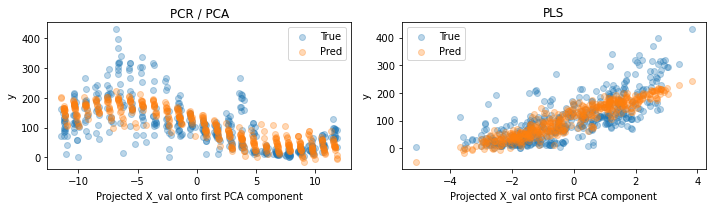

In [237]:
# PCR vs. PLS plot
pca = pcr[0:2] # Preprocess to PCA
fig, axes = plt.subplots(1, 2, figsize=(10,3))
# PCA vs PCR
axes[0].scatter(
    pca.transform(X_val)[:,0], y_val, alpha = 0.3, label = 'True' # alpha as transparaency
) # 1st principal component vs true y
axes[0].scatter(
    pca.transform(X_val)[:,0], pcr.predict(X_val), alpha = 0.3,  label = 'Pred'
) # 1st principal component vs pred y
axes[0].set(
    xlabel="Projected X_val onto first PCA component", ylabel='y', title = 'PCR / PCA'
)
axes[0].legend()
# PLS
axes[1].scatter(
    pls.transform(X_val)[:,0], y_val, alpha = 0.3, label = 'True'
)
axes[1].scatter(
    pls.transform(X_val)[:,0], pls.predict(X_val), alpha = 0.3, label = 'Pred'
)
axes[1].set(
    xlabel="Projected X_val onto first PCA component", ylabel='y', title = 'PLS'
)
axes[1].legend()
plt.tight_layout()
plt.savefig('plots/pcr_vs_pls.png', transparent=False, facecolor = 'white')

In [243]:
from sklearn.metrics import mean_squared_error
# R_squared
print(pcr.score(X_val, y_val).round(3)) # PCR = 0.544
print(pls.score(X_val, y_val).round(3)) # PLS = 0.617

# RMSE
print(np.sqrt(mean_squared_error(y_val, pcr.predict(X_val))).round(3)) # PCR = 54.958
print(np.sqrt(mean_squared_error(y_val, pls.predict(X_val))).round(3)) # PLS = 50.374

0.544
0.617
54.958
50.374
